# Chapter 6 Lab 3

## Goal
In this lab, we will walk through applying Fuzzy C-Means for clustering players in the DoTalicious data set. There are functions available for installation to perform Fuzzy C-Means ourside of sklearn. For example, there is scikit-fda - which must be installed apart from scikit. There is also skfuzzy aka scikit fuzzy. However, for our purposes in this lab, these are too complicated. Below, we've imported "fuzzy-c-means" which is available through PiPy and much simpler to use. 

## Brief Refresher
Fuzzy C-Means extends K-Means by allowing data points to have membership in more than on cluster. The algorithm returns a "percentage" - almost a likelihood - that a data point belongs to a certain group. For example, one point might be assigned 40% to Cluster 1 and 60% to Cluster 2. In this case, you'd lean toward it being part of Cluster 2.

## Preparation

First, import packages.

In [182]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, completeness_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from fcmeans import FCM
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer
import os

import warnings
warnings.filterwarnings('ignore')

## Step 1: Data Pre-processing

Let's read in the data and take a quick look at it.

In [183]:
dota_df1 = pd.read_csv('DoTalicious_cleaned1000players.csv')
#dota_df1.set_index('PlayerID', inplace=True)
dota_df1.drop(['PlayerID'], axis=1, inplace=True)
dota_df1.head()

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,SkillLevel,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
0,447,248,6,6,1111.360,1,2271,0.12,1889,4201,38736,3058,3456,355,151,1116780
1,66,39,0,0,989.882,1,373,0.13,450,745,4484,518,455,49,23,169800
2,3,0,0,0,1000.000,0,11,0.11,28,18,186,10,7,0,0,6180
3,100,59,5,1,1228.460,1,1079,0.26,448,934,13943,1885,1417,132,36,250200
4,1,1,0,0,1020.000,0,9,0.28,2,10,38,8,3,0,0,1944


In [184]:
dota_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GamesPlayed       868 non-null    int64  
 1   GamesWon          868 non-null    int64  
 2   GamesLeft         868 non-null    int64  
 3   Ditches           868 non-null    int64  
 4   Points            868 non-null    float64
 5   SkillLevel        868 non-null    object 
 6   Kills             868 non-null    int64  
 7   KillsPerMin       868 non-null    float64
 8    Deaths           868 non-null    int64  
 9   Assists           868 non-null    int64  
 10  CreepsKilled      868 non-null    int64  
 11  CreepsDenied      868 non-null    int64  
 12   NeutralsKilled   868 non-null    int64  
 13   TowersDestroyed  868 non-null    int64  
 14   RaxsDestroyed    868 non-null    int64  
 15   TotalTime        868 non-null    object 
dtypes: float64(2), int64(12), object(2)
memory u

Notice that we will need to change some data types.

In [185]:
dota_df1[' TotalTime'] = pd.to_numeric(dota_df1[' TotalTime'], errors="coerce")

We'll make a quick fix to an odd value in SkillLevel too. I've randomly chosen to make it a 1.

In [186]:
dota_df1.loc[dota_df1['SkillLevel'] ==' SkillLevelNull', 'SkillLevel'] = '1'

Lastly, let's work on the SkillLevel column!

In [187]:
dota_df1['SkillLevel'] = pd.Series(dota_df1['SkillLevel'].astype('category'))
dota_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   GamesPlayed       868 non-null    int64   
 1   GamesWon          868 non-null    int64   
 2   GamesLeft         868 non-null    int64   
 3   Ditches           868 non-null    int64   
 4   Points            868 non-null    float64 
 5   SkillLevel        868 non-null    category
 6   Kills             868 non-null    int64   
 7   KillsPerMin       868 non-null    float64 
 8    Deaths           868 non-null    int64   
 9   Assists           868 non-null    int64   
 10  CreepsKilled      868 non-null    int64   
 11  CreepsDenied      868 non-null    int64   
 12   NeutralsKilled   868 non-null    int64   
 13   TowersDestroyed  868 non-null    int64   
 14   RaxsDestroyed    868 non-null    int64   
 15   TotalTime        867 non-null    float64 
dtypes: category(1), float64(3)

In [188]:
dota_df1['SkillLevel'] = dota_df1['SkillLevel'].cat.rename_categories({'0':'N', '1':'B', '2':'I', '3':'A'})
dota_df1.head()

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,SkillLevel,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
0,447,248,6,6,1111.360,B,2271,0.12,1889,4201,38736,3058,3456,355,151,1116780.0
1,66,39,0,0,989.882,B,373,0.13,450,745,4484,518,455,49,23,169800.0
2,3,0,0,0,1000.000,N,11,0.11,28,18,186,10,7,0,0,6180.0
3,100,59,5,1,1228.460,B,1079,0.26,448,934,13943,1885,1417,132,36,250200.0
4,1,1,0,0,1020.000,N,9,0.28,2,10,38,8,3,0,0,1944.0


Next, let's check for null values and remove those.

In [189]:
dota_df1.isna().sum().sum()

1

In [190]:
dota_df1[dota_df1.isnull().any(axis=1)]

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,SkillLevel,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
517,0,0,0,0,1000.0,N,0,0.0,0,0,0,0,0,0,0,NaN


In [191]:
dota_df1.drop([517], inplace=True)

In [192]:
dota_df1.isna().sum().sum()

0

Also, since SkillLevel is categorical, sklearn dbscan cannot use it. We will copy it into a dataframe of its own (which will come in handy for us at the end of the lab).

In [193]:
dota_level = pd.DataFrame(dota_df1['SkillLevel']) # We're going to use this at the end of the lab!
dota_df1.drop(['SkillLevel'], axis=1, inplace=True)
dota_df1.head()

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
0,447,248,6,6,1111.360,2271,0.12,1889,4201,38736,3058,3456,355,151,1116780.0
1,66,39,0,0,989.882,373,0.13,450,745,4484,518,455,49,23,169800.0
2,3,0,0,0,1000.000,11,0.11,28,18,186,10,7,0,0,6180.0
3,100,59,5,1,1228.460,1079,0.26,448,934,13943,1885,1417,132,36,250200.0
4,1,1,0,0,1020.000,9,0.28,2,10,38,8,3,0,0,1944.0


In [194]:
dota_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 867 entries, 0 to 867
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GamesPlayed       867 non-null    int64  
 1   GamesWon          867 non-null    int64  
 2   GamesLeft         867 non-null    int64  
 3   Ditches           867 non-null    int64  
 4   Points            867 non-null    float64
 5   Kills             867 non-null    int64  
 6   KillsPerMin       867 non-null    float64
 7    Deaths           867 non-null    int64  
 8   Assists           867 non-null    int64  
 9   CreepsKilled      867 non-null    int64  
 10  CreepsDenied      867 non-null    int64  
 11   NeutralsKilled   867 non-null    int64  
 12   TowersDestroyed  867 non-null    int64  
 13   RaxsDestroyed    867 non-null    int64  
 14   TotalTime        867 non-null    float64
dtypes: float64(3), int64(12)
memory usage: 108.4 KB


Now that we've got some nice data, let's scale it. 

Also, let's get rid of some of the leading spaces in the columns names.

In [195]:
scaler = StandardScaler()
dota_df2 = pd.DataFrame(scaler.fit_transform(dota_df1), columns = dota_df1.columns)

dota_df2 = dota_df2.rename(columns=lambda x: x.strip())
dota_df2

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
0,1.726192,1.707709,1.343489,2.925072,0.805092,1.106833,-0.179345,1.116715,1.457369,1.571490,1.173404,0.740012,1.616977,1.625071,1.871061
1,-0.128221,-0.098239,-0.509820,-0.393625,-0.208189,-0.156910,-0.027349,-0.079019,-0.092739,-0.159318,-0.078688,-0.271179,-0.123951,-0.090333,-0.123286
2,-0.434856,-0.435234,-0.509820,-0.393625,-0.123792,-0.397940,-0.331341,-0.429678,-0.418818,-0.376502,-0.329107,-0.422133,-0.402727,-0.398570,-0.467871
3,0.037265,0.074579,1.034604,0.159491,1.781855,0.313165,1.948600,-0.080680,-0.007967,0.318661,0.595174,0.052969,0.348262,0.083887,0.046037
4,-0.444591,-0.426593,-0.509820,-0.393625,0.043034,-0.399271,2.252592,-0.451283,-0.422406,-0.383981,-0.330093,-0.423481,-0.402727,-0.398570,-0.476792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,-0.444591,-0.435234,-0.509820,-0.393625,-0.123792,-0.401935,0.428639,-0.447959,-0.423303,-0.382111,-0.330586,-0.419100,-0.402727,-0.398570,-0.476899
863,-0.332644,-0.357466,-0.200936,-0.393625,-0.753041,-0.342010,-0.635333,-0.300882,-0.347054,-0.321928,-0.271432,-0.294091,-0.345834,-0.371767,-0.350987
864,-0.444591,-0.435234,-0.509820,-0.393625,-0.123792,-0.404598,-1.395313,-0.448790,-0.426443,-0.384992,-0.333543,-0.424491,-0.402727,-0.398570,-0.477371
865,0.061601,0.221474,-0.200936,0.159491,1.076935,0.558856,3.164568,0.107114,0.089363,0.153523,0.125393,0.030730,0.371019,0.271510,0.056272


## Step 2: Tune DBSCAN hyperparameters

The two hyperparameters we can tune are eps and min_samples. eps is the max distance between two samples that will be allowed in order for one to be considered a neighbor of the other. min_samples sets the min number of data points around another data point in order for the that data point to be considered a cluster core point.

Since DBSCAN is non-parametric, we cannot use a convenient tool such as GridSearchCV where we drop in a series of options for each parameter and run all combinations.

Traditionally, you could also use the "elbow" method here as well for eps. Let's try this now.

Text(0, 0.5, 'Distance')

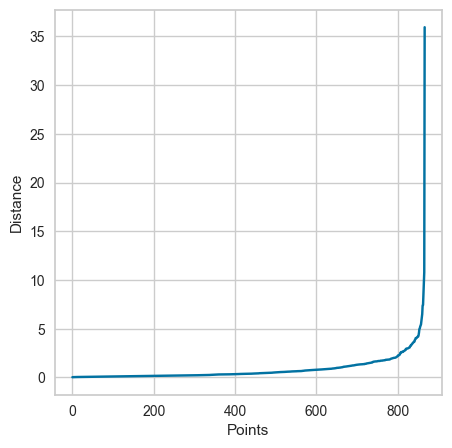

In [196]:
nearest_neighbors = NearestNeighbors(n_neighbors=29)
neighbors = nearest_neighbors.fit(dota_df2)

distances, indices = neighbors.kneighbors(dota_df2)
distances = np.sort(distances[:,4], axis=0)

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

This graph is reasonably hard to interpret. However, it appears as if the slope begins to pick up soon after 1. We'll add some additional parameter options just to make sure.

In [197]:
range_eps = [1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5]

for i in range_eps:
    print("eps value: " + str(i))
    dota_dbscan = DBSCAN(eps=i, min_samples=5).fit(dota_df2)
    core_mask = np.zeros_like(dota_dbscan.labels_, dtype=bool)
    core_mask[dota_dbscan.core_sample_indices_] = True
    labels = dota_dbscan.labels_
    print(set(labels))
    sil_score2 = silhouette_score(dota_df2, labels)
    print("For eps value " + str(i), "the avg silhouette score is: ", sil_score2)

eps value: 1.2
{0, 1, -1}
For eps value 1.2 the avg silhouette score is:  0.4035730151648601
eps value: 1.4
{0, 1, -1}
For eps value 1.4 the avg silhouette score is:  0.48069729039978426
eps value: 1.6
{0, -1}
For eps value 1.6 the avg silhouette score is:  0.6747401863527891
eps value: 1.8
{0, -1}
For eps value 1.8 the avg silhouette score is:  0.7103433381093356
eps value: 2.0
{0, -1}
For eps value 2.0 the avg silhouette score is:  0.7321311466027242
eps value: 2.2
{0, -1}
For eps value 2.2 the avg silhouette score is:  0.7398767008588721
eps value: 2.4
{0, -1}
For eps value 2.4 the avg silhouette score is:  0.7509820509032499
eps value: 4.0
{0, -1}
For eps value 4.0 the avg silhouette score is:  0.8194137241658501
eps value: 4.5
{0, -1}
For eps value 4.5 the avg silhouette score is:  0.8349818704559877
eps value: 5.0
{0, -1}
For eps value 5.0 the avg silhouette score is:  0.8523779944655068
eps value: 5.5
{0, -1}
For eps value 5.5 the avg silhouette score is:  0.8576242023253788
eps

From the analysis above, we see that the suggest optimal eps is 1.4 or 1.6 because of the jump in the silhouette score. Beyond this, the gains are small.

Given that, we can find the optimal min_samples - given that we will stick with k = 5 from Lab 1. Whatever combination of eps= 1.4 and min_samples gives us k = 5 will be the combination with which we will proceed.

Let's pick a range of min_samples to try and then loop through a DBSCAN and try each one, picking the min_sample with the best silhouette score.

In [198]:
minsamp = range(2, 11)
for i in minsamp:
    print(" If we set min_samp to " +str(i))
    dota_dbscan = DBSCAN(eps=1.4, min_samples=i).fit(dota_df2)
    core_mask = np.zeros_like(dota_dbscan.labels_, dtype=bool)
    core_mask[dota_dbscan.core_sample_indices_] = True
    labels = set([label for label in dota_dbscan.labels_ if label >= 0])
    print(set(labels))
    print("For a min_sample = "+str(i), "The optimal clusters are "+str(len(set(labels))))
    

 If we set min_samp to 2
{0, 1, 2, 3, 4, 5, 6, 7, 8}
For a min_sample = 2 The optimal clusters are 9
 If we set min_samp to 3
{0, 1, 2, 3, 4}
For a min_sample = 3 The optimal clusters are 5
 If we set min_samp to 4
{0, 1, 2}
For a min_sample = 4 The optimal clusters are 3
 If we set min_samp to 5
{0, 1}
For a min_sample = 5 The optimal clusters are 2
 If we set min_samp to 6
{0}
For a min_sample = 6 The optimal clusters are 1
 If we set min_samp to 7
{0}
For a min_sample = 7 The optimal clusters are 1
 If we set min_samp to 8
{0}
For a min_sample = 8 The optimal clusters are 1
 If we set min_samp to 9
{0}
For a min_sample = 9 The optimal clusters are 1
 If we set min_samp to 10
{0}
For a min_sample = 10 The optimal clusters are 1


So, for eps = 1.4 and min_samples = 3, we get 5 clusters. Let's use these parameters to cluster and then evaluate.

## Step 3: Run DBSCAN

In [199]:
dota_dbscan = DBSCAN(eps=1.4, min_samples=3).fit(dota_df2)
labels = dota_dbscan.labels_

After some tweaking...

In [200]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 5
Estimated number of noise points: 103


In [201]:
silhouette_score(dota_df2, labels)

0.38226631099265534

The silhouette score ranges from a low of -1 to high of 1. Our score of 0.38 is relatively strong. More on this later.

## Step 4: Visualize the result

In [202]:
dota_df2['cluster'] = labels
dota_df2

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime,cluster
0,1.726192,1.707709,1.343489,2.925072,0.805092,1.106833,-0.179345,1.116715,1.457369,1.571490,1.173404,0.740012,1.616977,1.625071,1.871061,-1
1,-0.128221,-0.098239,-0.509820,-0.393625,-0.208189,-0.156910,-0.027349,-0.079019,-0.092739,-0.159318,-0.078688,-0.271179,-0.123951,-0.090333,-0.123286,0
2,-0.434856,-0.435234,-0.509820,-0.393625,-0.123792,-0.397940,-0.331341,-0.429678,-0.418818,-0.376502,-0.329107,-0.422133,-0.402727,-0.398570,-0.467871,0
3,0.037265,0.074579,1.034604,0.159491,1.781855,0.313165,1.948600,-0.080680,-0.007967,0.318661,0.595174,0.052969,0.348262,0.083887,0.046037,-1
4,-0.444591,-0.426593,-0.509820,-0.393625,0.043034,-0.399271,2.252592,-0.451283,-0.422406,-0.383981,-0.330093,-0.423481,-0.402727,-0.398570,-0.476792,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,-0.444591,-0.435234,-0.509820,-0.393625,-0.123792,-0.401935,0.428639,-0.447959,-0.423303,-0.382111,-0.330586,-0.419100,-0.402727,-0.398570,-0.476899,0
863,-0.332644,-0.357466,-0.200936,-0.393625,-0.753041,-0.342010,-0.635333,-0.300882,-0.347054,-0.321928,-0.271432,-0.294091,-0.345834,-0.371767,-0.350987,0
864,-0.444591,-0.435234,-0.509820,-0.393625,-0.123792,-0.404598,-1.395313,-0.448790,-0.426443,-0.384992,-0.333543,-0.424491,-0.402727,-0.398570,-0.477371,0
865,0.061601,0.221474,-0.200936,0.159491,1.076935,0.558856,3.164568,0.107114,0.089363,0.153523,0.125393,0.030730,0.371019,0.271510,0.056272,-1


In [203]:
pc_model = PCA(n_components=2)
dota_pc = pc_model.fit_transform(dota_df2)

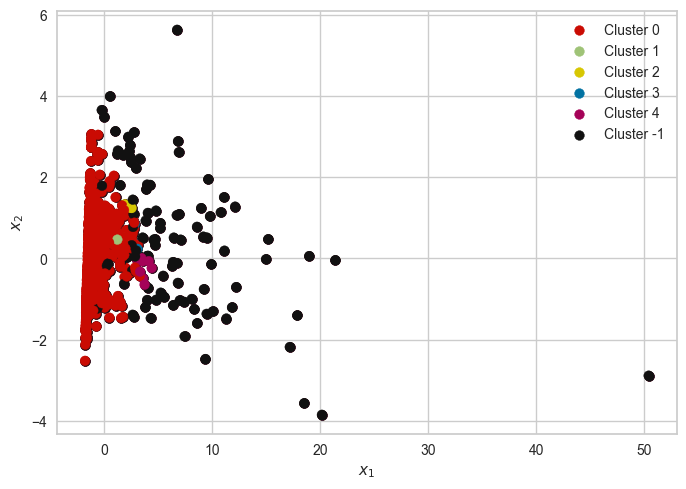

In [204]:
color_key = {}
color_key[0] = 'r'
color_key[1] = 'g'
color_key[2] = 'y'
color_key[3] = 'b'
color_key[4] = 'm'
color_key[-1] = 'k'

color_vec = [color_key[label] for label in labels]

r = plt.scatter(dota_pc[:, 0], dota_pc[:, 1], color='r')
g = plt.scatter(dota_pc[:, 0], dota_pc[:, 1], color='g')
y = plt.scatter(dota_pc[:, 0], dota_pc[:, 1], color='y')
b = plt.scatter(dota_pc[:, 0], dota_pc[:, 1], color='b')
m = plt.scatter(dota_pc[:, 0], dota_pc[:, 1], color='m')
k = plt.scatter(dota_pc[:, 0], dota_pc[:, 1], color='k')

#plt.figure(figsize = (9,9))
plt.scatter(dota_pc[:, 0], dota_pc[:, 1], c = color_vec)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.legend((r, g, y, b, m, k), ('Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster -1'))

plt.show()


At this point, it would not serve much purpose to add symbols for the SkillLevel column as we have in the previous labs. The points are cluster too tightly together.

The question now is whether or not this visualization is good news or bad news.

The answer is: It depends. Consult the text for a discussion of clustering and some of its more common use cases in the game industry.